**Autores**

David Bolea

Marc Domènech

**Dataset**

Vehicles: https://www.kaggle.com/austinreese/craigslist-carstrucks-data



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerias

In [ ]:
!pip install dython

In [ ]:
import numpy as np
from numpy.random import normal

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv


from time import time

pd.set_option('precision', 3)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Extra imports
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,VotingRegressor,GradientBoostingRegressor,StackingRegressor,ExtraTreesRegressor
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, mean_absolute_error

from dython.nominal import associations

import warnings
warnings.filterwarnings('ignore')

# Leer Dataset

Leemos el Dataset y mostramos las primeras filas para coger una idea del dataset

In [ ]:
# Leemos el Dataset
data = pd.read_csv('/content/drive/MyDrive/APA/APA Practica/vehicles.csv')
data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7184791621,https://duluth.craigslist.org/ctd/d/duluth-200...,duluth / superior,https://duluth.craigslist.org,6995,2000.0,gmc,new sierra 1500,excellent,8 cylinders,gas,167783.0,clean,automatic,1GTEK19T3YE366021,4wd,NaN,NaN,red,https://images.craigslist.org/00n0n_f06ykBMcdh...,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,NaN,mn,46.843,-92.255
1,7184773187,https://duluth.craigslist.org/cto/d/saginaw-20...,duluth / superior,https://duluth.craigslist.org,8750,2013.0,hyundai,sonata,excellent,4 cylinders,gas,90821.0,clean,automatic,NaN,fwd,NaN,NaN,grey,https://images.craigslist.org/00d0d_kgZ6xoeRw2...,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,NaN,mn,46.907,-92.464
2,7193375964,https://newhaven.craigslist.org/cto/d/stratfor...,new haven,https://newhaven.craigslist.org,10900,2013.0,toyota,prius,good,4 cylinders,hybrid,92800.0,clean,automatic,NaN,fwd,NaN,NaN,blue,https://images.craigslist.org/00d0d_3sHGxPbY2O...,2013 Prius V Model Two. One owner—must sell my...,NaN,ct,41.177,-73.134
3,7195108810,https://albuquerque.craigslist.org/cto/d/albuq...,albuquerque,https://albuquerque.craigslist.org,12500,2003.0,mitsubishi,lancer,good,4 cylinders,gas,NaN,clean,manual,NaN,4wd,mid-size,sedan,grey,https://images.craigslist.org/00m0m_4a8Pb6JbMG...,"2003 Mitsubishi Lancer Evolution, silver. Abo...",NaN,nm,35.187,-106.665
4,7184712241,https://duluth.craigslist.org/ctd/d/rush-city-...,duluth / superior,https://duluth.craigslist.org,16995,2007.0,gmc,sierra classic 2500hd,good,8 cylinders,diesel,254217.0,clean,automatic,1GTHK23D57F102022,4wd,full-size,truck,white,https://images.craigslist.org/01414_g093aPtSMW...,"**Bad Credit, No Credit... No Problem!**2007 G...",NaN,mn,45.684,-92.965


In [ ]:
# Mostramos una breve descripción de los datos
data.describe(include='all')

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
count,4.239e+05,423857,423857,423857,4.239e+05,328743.000,313242,325384,176719,197679,327214,2.706e+05,327759,328065,184420,231119,102627,241157,222203,329661,329654,0.0,423857,324404.000,324404.000
unique,NaN,423857,404,413,NaN,NaN,43,27042,6,8,5,NaN,6,3,103588,3,4,13,12,222413,275765,NaN,51,NaN,NaN
top,NaN,https://visalia.craigslist.org/cto/d/springvil...,columbus,https://salem.craigslist.org,NaN,NaN,ford,f-150,excellent,6 cylinders,gas,NaN,clean,automatic,1HTMRAAM19J040080,4wd,full-size,sedan,white,https://images.craigslist.org/00H0H_lwWjXSEWNa...,VISIT OUR WEBSITE WWW.DIRECTDETAILOFOH.COM HTT...,NaN,ca,NaN,NaN
freq,NaN,1,3296,2985,NaN,NaN,59786,6073,85254,70130,286775,NaN,315607,292619,133,99347,52820,64842,57646,2106,144,NaN,45798,NaN,NaN
mean,7.191e+09,NaN,NaN,NaN,5.779e+04,2009.827,NaN,NaN,NaN,NaN,NaN,9.943e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.731,-93.949
std,5.159e+06,NaN,NaN,NaN,1.003e+07,10.136,NaN,NaN,NaN,NaN,NaN,1.205e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.903,17.931
min,7.178e+09,NaN,NaN,NaN,0.000e+00,1900.000,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-80.386,-161.394
25%,7.187e+09,NaN,NaN,NaN,4.499e+03,2007.000,NaN,NaN,NaN,NaN,NaN,4.432e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.054,-106.678
50%,7.192e+09,NaN,NaN,NaN,9.995e+03,2012.000,NaN,NaN,NaN,NaN,NaN,9.175e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.367,-88.010
75%,7.195e+09,NaN,NaN,NaN,1.900e+04,2016.000,NaN,NaN,NaN,NaN,NaN,1.372e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.517,-80.832


In [ ]:
# Función que nos servirá para mostrar el porcentage de nulls que tiene cada 
# columna de la tabla
def percentatge_nulls(data):
  null_values = data.isnull().sum()
  null_values = pd.DataFrame(null_values,columns=['null'])
  j = 1
  sum_tot = len(data)
  null_values['percent'] = null_values['null']/sum_tot
  return round(null_values * 100, 3).sort_values('percent', ascending=False)

In [ ]:
percentatge_nulls(data)

,null,percent
county,42385700,100.000
size,32123000,75.787
condition,24713800,58.307
vin,23943700,56.490
cylinders,22617800,53.362
paint_color,20165400,47.576
drive,19273800,45.472
type,18270000,43.104
odometer,15327200,36.161
manufacturer,11061500,26.097


Nos quedamos con todas aquellas columnas que creemos que son relevantes para solucionar el problema o que tienen demasiados nulls

Para este proyecto disponemos de un dataset con variables tanto numéricas como categóricas y es por ello que tendremos que ir con cuidado a la hora del preprocesado de datos. 

Solo al ver el dataset ya nos damos cuenta de que hay atributos que no son necesarios para predecir el precio y otros que tienen demasiados valores nulos como para que tenerlos en cuenta. Estos atributos son los siguientes: 

id, url, region_url, title_status, vin, size, paint_color, image_url, description, county, state, lat, long y region.


In [ ]:
# Nos quedamos solo con las columnas útiles
# Borramos todas las columnas que no son importantes, como la descripción... Y también todas aquellas que tiene muchos nulls (size).
columnas_borrar = ['id', 'url', 'region_url', 'title_status', 'vin', 'size', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'region']

data = data.drop(columns = columnas_borrar)

In [ ]:
data.describe(include='all')

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type
count,4.239e+05,328743.000,313242,325384,176719,197679,327214,2.706e+05,328065,231119,241157
unique,NaN,NaN,43,27042,6,8,5,NaN,3,3,13
top,NaN,NaN,ford,f-150,excellent,6 cylinders,gas,NaN,automatic,4wd,sedan
freq,NaN,NaN,59786,6073,85254,70130,286775,NaN,292619,99347,64842
mean,5.779e+04,2009.827,NaN,NaN,NaN,NaN,NaN,9.943e+04,NaN,NaN,NaN
std,1.003e+07,10.136,NaN,NaN,NaN,NaN,NaN,1.205e+05,NaN,NaN,NaN
min,0.000e+00,1900.000,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN
25%,4.499e+03,2007.000,NaN,NaN,NaN,NaN,NaN,4.432e+04,NaN,NaN,NaN
50%,9.995e+03,2012.000,NaN,NaN,NaN,NaN,NaN,9.175e+04,NaN,NaN,NaN
75%,1.900e+04,2016.000,NaN,NaN,NaN,NaN,NaN,1.372e+05,NaN,NaN,NaN


In [ ]:
percentatge_nulls(data)

,null,percent
condition,24713800,58.307
cylinders,22617800,53.362
drive,19273800,45.472
type,18270000,43.104
odometer,15327200,36.161
manufacturer,11061500,26.097
model,9847300,23.233
fuel,9664300,22.801
transmission,9579200,22.600
year,9511400,22.440


# Preprocesado

En este apartado iremos viendo columna a columna como tenemos los datos del dataset para ver si tenemos que preprocesarlos de algún modo.

## Columna: Price

El atributo precio representa el precio que tiene el coche en cuestión. Este atributo será el target que intentaremos predecir. Su distribución antes de aplicar el preprocesado es el siguiente:

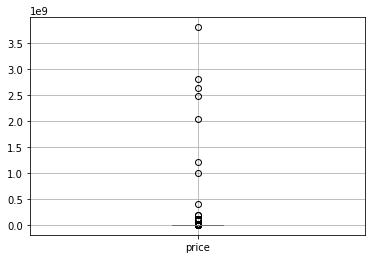

In [ ]:
# Mostramos un boxpolot con los datos originales
data.boxplot(column='price')

In [ ]:
# Mostramos cuantas muestras hay con un precio de 0 €
print("Coches con precios de 0€:", (data.price == 0).sum())

Coches con precios de 0€: 35025


Podemos observar como por un lado tenemos demasiados outliers, por lo tanto intentaremos aplicar un IQR para ver si podemos solucionar el problema.

Por el otro lado vemos que hay 35.025 coches que tienen un precio de 0€. Estos coches hemos decidido eliminarlos ya que consideramos que son valores sin sentido.

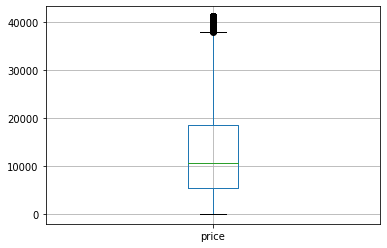

In [ ]:
# Borramos los 0
data = data[data.price != 0]

# Aplicamos el IQR para ver si podemos quitar los outliers
Q1 = data.price.quantile(0.25)
Q3 = data.price.quantile(0.75)

IQR = Q3 - Q1

minimo_outliers = (Q1 - 1.5 * IQR)
maximo_outliers = (Q3 + 1.5 * IQR) 

dataAux = data[(data.price >= minimo_outliers) & (data.price <= maximo_outliers)]

dataAux.boxplot(column='price')

Después de eliminar los coches que tenían como precio 0€, vemos como el IQR no ha acabado de solucionarnos el problema de los outliers. Por esta razón hemos decidido aplicar los percentiles 90-10 para quedarnos con los datos que hemos considerado que son más relevantes.

2800.0 32898.0


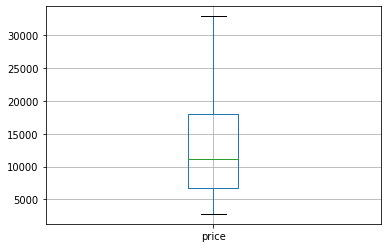

In [ ]:
# Aplicamos el percentil para lidiar con los outliers
price_ordenado = sorted(data.price)
quantile1, quantile3= np.percentile(price_ordenado,[10,90])
print(quantile1, quantile3)

data = data[(data.price < quantile3) & (data.price >= quantile1 )]

data.boxplot(column='price')


## Columna: Odometer

Odometer, representa los kilómetros recorridos por el coche. Para esta columna hemos dibujado un kdeplot que nos muestra la distribución de los datos. 

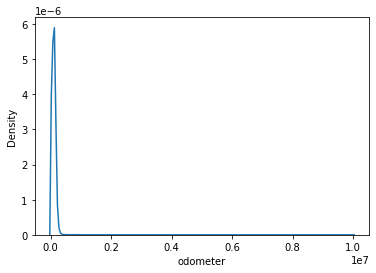

In [ ]:
# Mostramos los datos originales
sns.kdeplot(data=data.odometer)

Como podemos observar tenemos bastantes outliers en este atributo. Viendo la gráfica, nos damos cuenta de que la mayor parte de ellos son coches que han recorrido menos de unos 325.000 km. Es por eso que hemos decidido cortar, y quedarnos con todos los menores a 325.000. Además, valores tan elevados de odometer no son reales.

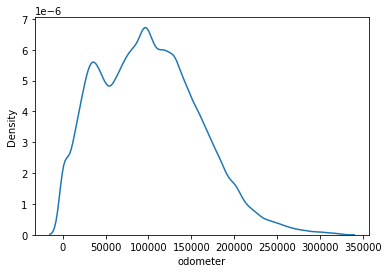

In [ ]:
# Basandonos en el scatterplot hemos decidido coger los datos que estan por debajo de 325.000

data = data[(data.odometer <= 325000)]
sns.kdeplot(data=data.odometer)

## Columna: Year

Year, representa el año de fabricación del automóvil. La distribución de este atributo es la siguiente:

<Figure size 1080x648 with 0 Axes>

[Text(0, 0, '1901.0'),
 Text(0, 0, '1919.0'),
 Text(0, 0, '1920.0'),
 Text(0, 0, '1921.0'),
 Text(0, 0, '1923.0'),
 Text(0, 0, '1924.0'),
 Text(0, 0, '1926.0'),
 Text(0, 0, '1927.0'),
 Text(0, 0, '1928.0'),
 Text(0, 0, '1929.0'),
 Text(0, 0, '1930.0'),
 Text(0, 0, '1931.0'),
 Text(0, 0, '1932.0'),
 Text(0, 0, '1933.0'),
 Text(0, 0, '1934.0'),
 Text(0, 0, '1935.0'),
 Text(0, 0, '1936.0'),
 Text(0, 0, '1937.0'),
 Text(0, 0, '1938.0'),
 Text(0, 0, '1939.0'),
 Text(0, 0, '1940.0'),
 Text(0, 0, '1941.0'),
 Text(0, 0, '1942.0'),
 Text(0, 0, '1946.0'),
 Text(0, 0, '1947.0'),
 Text(0, 0, '1948.0'),
 Text(0, 0, '1949.0'),
 Text(0, 0, '1950.0'),
 Text(0, 0, '1951.0'),
 Text(0, 0, '1952.0'),
 Text(0, 0, '1953.0'),
 Text(0, 0, '1954.0'),
 Text(0, 0, '1955.0'),
 Text(0, 0, '1956.0'),
 Text(0, 0, '1957.0'),
 Text(0, 0, '1958.0'),
 Text(0, 0, '1959.0'),
 Text(0, 0, '1960.0'),
 Text(0, 0, '1961.0'),
 Text(0, 0, '1962.0'),
 Text(0, 0, '1963.0'),
 Text(0, 0, '1964.0'),
 Text(0, 0, '1965.0'),
 Text(0, 0,

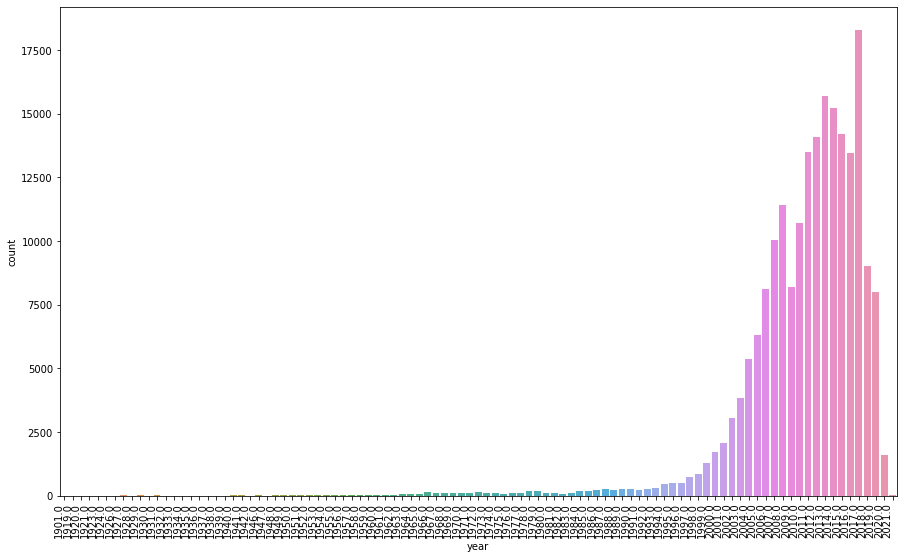

In [ ]:
# Mostramos los datos originales de year.
plt.figure(figsize=(15,9))
ax = sns.countplot(x='year',data=data);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=10);

data = data[data.year > 2000]

Viendo las distribución de los datos, podemos ver como la gran mayoría de los datos los podemos encontrar a partir del año 2000 hacia adelante. Por este motivo hemos decidido cortar, y eliminar los anteriores a esta fecha.

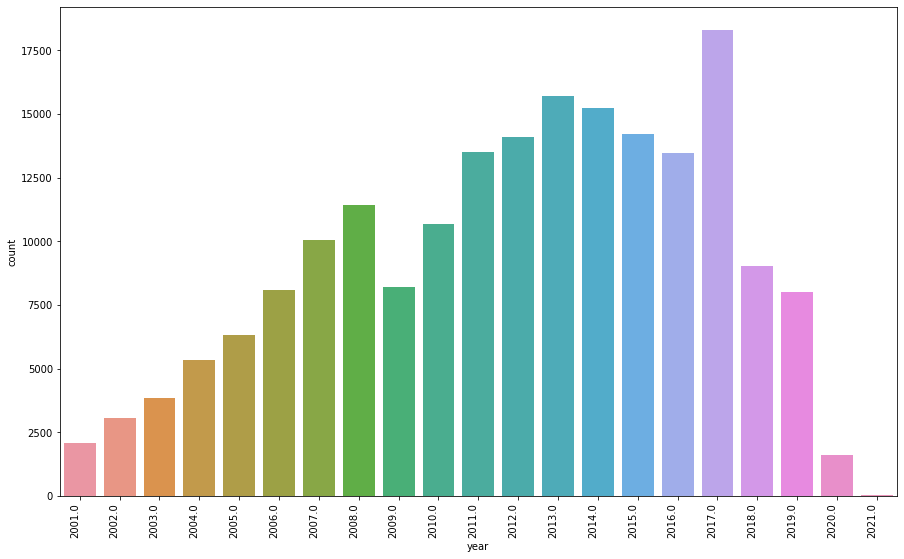

In [ ]:
# Mostramos los datos preprocesados de year.
plt.figure(figsize=(15,9))
ax = sns.countplot(x='year',data=data);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=10);

## Columna: Cylinders

Este atributo representa el número de cilindros que tiene el coche. Es un atributo categórico, por eso vamos a mostrar qué valores puede tomar.

In [ ]:
# Mostramos que valores puede tomar cylinders
data.cylinders.value_counts()

4 cylinders     51990
6 cylinders     45457
8 cylinders     26979
5 cylinders      1192
10 cylinders      478
other             315
3 cylinders       299
12 cylinders       33
Name: cylinders, dtype: int64

Lo primero que hemos hecho ha sido eliminar la palabra cylinder de nuestros valores, es decir, hemos pasado de tener ‘6 cylinders’ a tener ‘6’. 

Seguidamente nos hemos quedado con las muestras que tienen un valor definido de cilindros y, por lo tanto, hemos decidido desechar todas las que tenían el valor ‘other’. Hemos decidido tomar esta decisión debido a que ‘other’ puede ser cualquier valor e intentar imputarlo sería inventarnos posibles valores.

Finalmente, debido a que intentamos imputar los valores nulos mediante ffill y nos dio unos resultados nefastos, decidimos hacer un drop de estos valores y así conseguimos un valor de predicción bastante mejor.


In [ ]:
# Eliminamos el string cylinders del valor
data.cylinders = data.cylinders.str.replace(' cylinders','')


# Eliminamos los other ya que puede ser cualquier valor
data = data[data.cylinders != 'other']

# Vemos que imputando no sale bien
data = data.dropna(subset=['cylinders'])

data.cylinders.value_counts()

4     51990
6     45457
8     26979
5      1192
10      478
3       299
12       33
Name: cylinders, dtype: int64

## Columna: Condition

Este atributo se refiere a en qué condiciones se encuentra el coche. Su valor es categórico.

In [ ]:
# Mostramos que valores puede tomar originalmente
data.condition.value_counts()

excellent    46562
good         31170
like new      9683
fair          1221
new            259
salvage         82
Name: condition, dtype: int64

En el momento de tratar la variable condition nos surgió un problema. Al principio de todo, cuando calculamos el porcentaje de nulos de cada clase, obtuvimos que condition tenía casi un 60% de valores nulos y nos planteamos la opción de descartarlo. Por otro lado, pensamos que no debíamos hacer eso ya que la condición de un coche es una característica importante a la hora de ponerle un precio.

Finalmente nos dimos cuenta que la condición de un coche guarda una gran relación con la columna odometer, ya que contra mas kilometros recorre un coche más fácil es que un coche se encuentre en peor estado. Es por ello que hemos utilizado la variable odometer para imputar los valores nulos de condition.


In [ ]:
# Para imputar los valores nulos de condition nos basaremos en la variable odometer ya que parecen tener una buena relacion.
# Calculamos la media de los valores de odometer para cada valor de condition
new_odo_mean = data[data['condition'] == 'new']['odometer'].mean()
excellent_odo_mean = data[data['condition'] == 'excellent']['odometer'].mean()
good_odo_mean = data[data['condition'] == 'good']['odometer'].mean()
like_new_odo_mean = data[data['condition'] == 'like new']['odometer'].mean()
salvage_odo_mean = data[data['condition'] == 'salvage']['odometer'].mean()
fair_odo_mean = data[data['condition'] == 'fair']['odometer'].mean()

# NEW
data.loc[data['odometer'] >= new_odo_mean, 'condition'] = data.loc[data['odometer'] >= new_odo_mean, 'condition'].fillna('new')

# LIKE NEW
data.loc[((data['odometer'] < excellent_odo_mean) & 
       (data['odometer'] >= like_new_odo_mean)), 'condition'] = data.loc[((data['odometer'] < excellent_odo_mean) & 
       (data['odometer'] >= like_new_odo_mean)), 'condition'].fillna('like new')

# EXCELLENT
data.loc[((data['odometer'] < good_odo_mean) & 
       (data['odometer'] >= excellent_odo_mean)), 'condition'] = data.loc[((data['odometer'] < good_odo_mean) & 
       (data['odometer'] >= excellent_odo_mean)), 'condition'].fillna('excellent')

# GOOD
data.loc[((data['odometer'] < like_new_odo_mean) & 
       (data['odometer'] >= good_odo_mean)), 'condition'] = data.loc[((data['odometer'] < like_new_odo_mean) & 
       (data['odometer'] >= good_odo_mean)), 'condition'].fillna('good')

# SALVAGE
data.loc[((data['odometer'] < good_odo_mean) & 
       (data['odometer'] >= fair_odo_mean)), 'condition'] = data.loc[((data['odometer'] < good_odo_mean) & 
       (data['odometer'] >= fair_odo_mean)), 'condition'].fillna('salvage')

# FAIR
data.loc[data['odometer'] <= fair_odo_mean, 'condition'] = data.loc[data['odometer'] <= fair_odo_mean, 'condition'].fillna('fair')


In [ ]:
# Mostramos que valores puede tomar despues de preprocesar
data.condition.value_counts()

excellent    46562
good         31170
new          23426
fair         15505
like new      9683
salvage         82
Name: condition, dtype: int64

## Columnas Restantes

A estas alturas ya hemos preprocesado todas aquellas columnas que tenían más missings. Por tanto, dado el tamaño de nuestro dataset, nos podemos permitir eliminar todos los nulos restantes debido a que las columnas que nos quedan por procesar tienen un porcentaje muy pequeño de estos. Entonces eliminaremos los nulos de las columnas siguientes:

- Fuel
- Transmission
- Model
- Manufacturer
- Type
- Drive

In [ ]:
# Mostramos los nulos de los atributos restantes
percentatge_nulls(data)

,null,percent
type,1358500,10.745
drive,1293400,10.230
manufacturer,316000,2.499
fuel,78800,0.623
model,55700,0.441
transmission,3700,0.029
price,0,0.000
year,0,0.000
condition,0,0.000
cylinders,0,0.000


In [ ]:
# Eliminamos todos los nulls ya que hay muy pocos
data = data.dropna(subset=['fuel','transmission','model','manufacturer', 'type', 'drive'])

In [ ]:
percentatge_nulls(data)

,null,percent
price,0,0.0
year,0,0.0
manufacturer,0,0.0
model,0,0.0
condition,0,0.0
cylinders,0,0.0
fuel,0,0.0
odometer,0,0.0
transmission,0,0.0
drive,0,0.0


## Relación de las variables

En este apartado estudiaremos como de relacionadas están nuestras variables respecto al precio. Lo dividiremos en dos partes: variables categóricas y numéricas.

### Categóricas

Para poder ver como de relacionadas están las variables categóricas respecto al precio, utilizaremos una tabla de asociaciones. La manera de interpretar esta tabla es mirando la primera columna, y contra más cercano esté el valor a 1  o a -1, más relacionada está esa variable con el precio del coche.

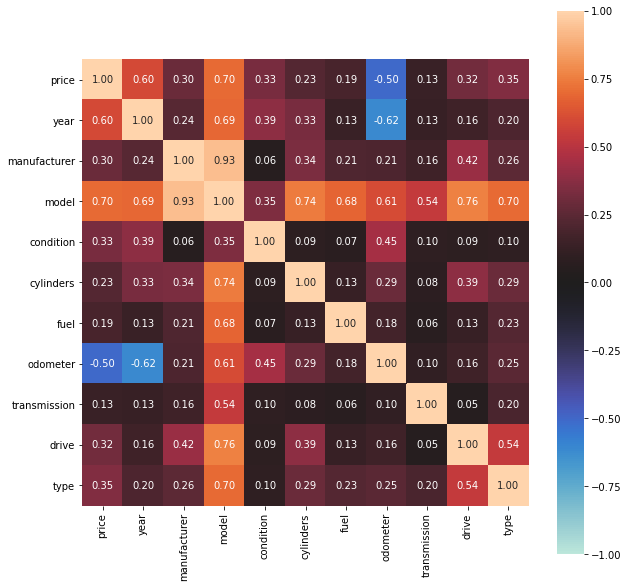

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type
price,1.000,0.597,0.295,0.701,0.329,0.231,0.190,-0.501,0.133,0.319,0.354
year,0.597,1.000,0.239,0.692,0.389,0.334,0.135,-0.616,0.128,0.161,0.204
manufacturer,0.295,0.239,1.000,0.934,0.061,0.337,0.214,0.209,0.162,0.415,0.257
model,0.701,0.692,0.934,1.000,0.351,0.743,0.681,0.606,0.535,0.760,0.696
condition,0.329,0.389,0.061,0.351,1.000,0.092,0.072,0.450,0.101,0.087,0.101
cylinders,0.231,0.334,0.337,0.743,0.092,1.000,0.131,0.292,0.084,0.385,0.294
fuel,0.190,0.135,0.214,0.681,0.072,0.131,1.000,0.177,0.064,0.131,0.231
odometer,-0.501,-0.616,0.209,0.606,0.450,0.292,0.177,1.000,0.104,0.158,0.246
transmission,0.133,0.128,0.162,0.535,0.101,0.084,0.064,0.104,1.000,0.052,0.200
drive,0.319,0.161,0.415,0.760,0.087,0.385,0.131,0.158,0.052,1.000,0.535


In [ ]:
# Mostramos la tabla de asociaciones para ver comomo de importantes son las 
# distintas columnas respecto el precio
output = associations(data, nan_strategy='drop_samples', figsize=(10,10))

correlation = output['corr']
ax = output['ax']

correlation

Por lo tanto, una vez analizada la tabla, podemos decir que las variables más relevantes a la hora de predecir el precio de un coche son:

- Model
- Condition
- Drive
- Type
- Manufacturer


### Numéricas

En el caso de las variables numéricas podemos observar como de relacionadas están respecto al precio utilizando un heatmap. La forma de interpretar esta tabla es la misma que en el caso de las categóricas, contra más cerca de 1 o -1 esté el valor, más relacionadas están las variables.

<Figure size 360x360 with 0 Axes>

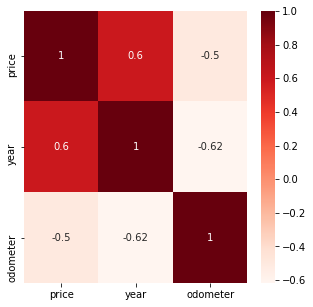

In [ ]:
# Muy relacionado con year, e inversamente relacionado con odometer
plt.figure(figsize=(5,5))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Por lo tanto, como podemos observar, en este caso todas las variables numéricas están altamente relacionadas con la variable precio.

## Codificación Variables Categóricas

Para transformar las variables categóricas en numéricas hemos decidido aplicar One Hot Encoding a aquellas variables que tengan pocos valores distintos y para las columnas que tienen muchos más valores posibles hemos aplicado un Label Encoding.
En nuestro caso, debido a que por ejemplo el modelo del coche (model) tiene más de 27 mil valores diferentes, aplicar one hot encoding a esta característica nos generaría más de 27 mil columnas y haría que nuestro dataset tuviera un tamaño demasiado grande.
Es por esto que una vez consultados cuantos valores puede tomar de cada variable categórica, hemos decidido aplicar Label Enconding a manufacturer, model y type. Por otro lado, hemos decidido aplicar one hot encoding a condition y drive.


In [ ]:
le_categorical_columns = ['manufacturer', 'model', 'type']
ohe_categorical_columns = ['condition', 'drive']

def LabelEncoding(df, categorical_columns):
  le = LabelEncoder()
  df[categorical_columns] = df[categorical_columns].apply(le.fit_transform) 
  return df 

def OneHotEncoding(df, categorical_columns):
  for column in categorical_columns:
    x_one_hot = pd.get_dummies(df[column], prefix=column)
    df = df.merge(x_one_hot,left_index=True,right_index=True)
    df = df.drop(columns=[column])
  return df

data = OneHotEncoding(data, ohe_categorical_columns)
data = LabelEncoding(data, le_categorical_columns)
data


,price,year,manufacturer,model,cylinders,fuel,odometer,transmission,type,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,drive_4wd,drive_fwd,drive_rwd
4,16995,2007.0,12,7001,8,diesel,254217.0,automatic,10,0,0,1,0,0,0,1,0,0
5,13995,2012.0,11,3373,6,gas,188406.0,automatic,10,0,0,1,0,0,0,1,0,0
6,7995,2010.0,7,2988,4,gas,108124.0,automatic,0,0,0,1,0,0,0,1,0,0
7,8995,2011.0,7,8069,6,gas,178054.0,automatic,0,0,0,1,0,0,0,1,0,0
8,10995,2014.0,11,3220,6,gas,170259.0,automatic,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423842,8700,2011.0,19,7338,6,gas,101873.0,automatic,0,0,0,1,0,0,0,1,0,0
423843,29500,2015.0,35,7641,6,gas,75000.0,automatic,8,0,0,0,1,0,0,1,0,0
423849,9885,2012.0,33,4074,4,gas,82000.0,automatic,4,1,0,0,0,0,0,1,0,0
423851,4800,2002.0,11,5553,6,gas,58000.0,automatic,3,0,0,1,0,0,0,0,0,1


## Normalización

Dado que tenemos rangos de datos muy distintos, por ejemplo entre el modelo del coche (model) y el año de fabricación (year), es necesario aplicar algún tipo de normalización/estandarización de los datos si queremos usar modelos que usen distancias euclídeas como por ejemplo el KNN.

In [ ]:
# Probamos diferentes maneras de normalizar/estandarizar nuestros datos para comprobar
# cual nos da mejores resultados
dataAux = data.copy()
min_max_scaler =  preprocessing.MinMaxScaler()
dataAux[['price_minMax', 'year_minMax', 'odometer_minMax']] = min_max_scaler.fit_transform(data[['price', 'year', 'odometer']])

std_scaler = preprocessing.StandardScaler()
dataAux[['price_std', 'year_std', 'odometer_std']]= preprocessing.scale(data[['price', 'year', 'odometer']])

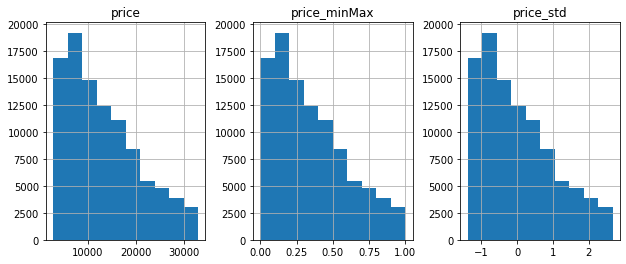

In [ ]:
# Comparativa entre price, aplicando MinMaxScaler y aplicando StandardScaler
dataAux[['price','price_minMax', 'price_std']].hist(figsize=(14,4), layout=(1,4));

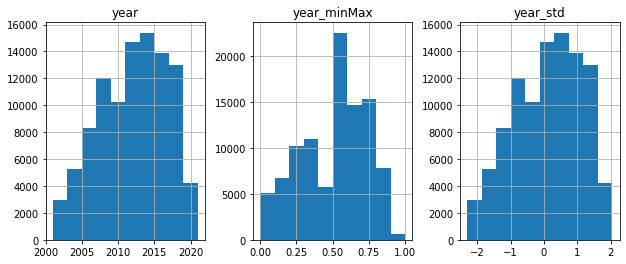

In [ ]:
# Comparativa entre year, aplicando MinMaxScaler y aplicando StandardScaler
dataAux[['year','year_minMax', 'year_std']].hist(figsize=(14,4), layout=(1,4));

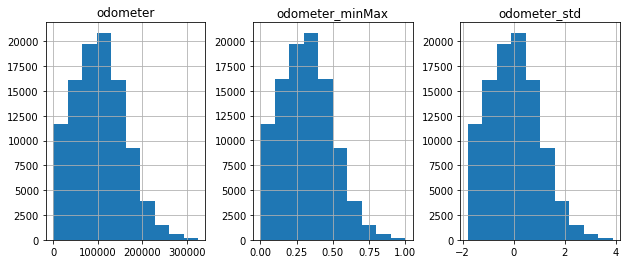

In [ ]:
# Comparativa entre odometer, aplicando MinMaxScaler y aplicando StandardScaler
dataAux[['odometer','odometer_minMax', 'odometer_std']].hist(figsize=(14,4), layout=(1,4));

Como podemos observar, cualquiera de las dos transformaciones mantiene la distribución de los datos y por lo tanto, decidimos usar MinMaxScaler junto a los atributos model y manufacturer.

In [ ]:
# Aplicamos MinMaxScaler a los datos numéricos
min_max_scaler =  preprocessing.MinMaxScaler()
data[['price', 'year', 'odometer', 'model', 'manufacturer']] = min_max_scaler.fit_transform(data[['price', 'year', 'odometer', 'model', 'manufacturer']])

# Features

Finalmente después del preprocesado y de mirar como de relevantes son cada una de las variables, obtenemos las columnas que usaremos para predecir el precio:

- Year
- Manufacturer
- Model
- Odometer
- Type
- Condition
- Drive

In [ ]:
data = data[['price', 'year', 'manufacturer', 'model',
       'odometer', 'type', 'condition_excellent',
       'condition_fair', 'condition_good', 'condition_like new',
       'condition_new', 'condition_salvage', 'drive_4wd', 'drive_fwd',
       'drive_rwd']]

# Features seran los atributos que utilizaremos para predecir      
features = data[['year', 'manufacturer', 'model',
       'odometer', 'type', 'condition_excellent',
       'condition_fair', 'condition_good', 'condition_like new',
       'condition_new', 'condition_salvage', 'drive_4wd', 'drive_fwd',
       'drive_rwd']]
       
# Target será nuestra variable a predecir
target = data[["price"]]

# Resumen de los Datos

Mostramos el dataset preprocesado

In [ ]:
data.describe(include='all')

,price,year,manufacturer,model,odometer,type,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,drive_4wd,drive_fwd,drive_rwd
count,99886.000,99886.000,99886.000,99886.000,99886.000,99886.000,99886.000,99886.000,99886.000,99886.000,99886.000,9.989e+04,99886.000,99886.000,99886.000
mean,0.341,0.528,0.462,0.500,0.318,5.752,0.368,0.137,0.241,0.076,0.177,6.608e-04,0.405,0.437,0.158
std,0.248,0.231,0.279,0.275,0.176,4.335,0.482,0.344,0.428,0.264,0.382,2.570e-02,0.491,0.496,0.365
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000e+00,0.000,0.000,0.000
25%,0.139,0.350,0.243,0.262,0.184,0.000,0.000,0.000,0.000,0.000,0.000,0.000e+00,0.000,0.000,0.000
50%,0.289,0.550,0.378,0.498,0.311,8.000,0.000,0.000,0.000,0.000,0.000,0.000e+00,0.000,0.000,0.000
75%,0.505,0.700,0.757,0.737,0.434,9.000,1.000,0.000,0.000,0.000,0.000,0.000e+00,1.000,1.000,0.000
max,1.000,1.000,1.000,1.000,1.000,12.000,1.000,1.000,1.000,1.000,1.000,1.000e+00,1.000,1.000,1.000


# Train / Val / Test

Ya que nuestro dataset es muy grande, nos podemos permitir tener una partición de train para entrenar los modelos, una de validación para poder comparar los modelos, y una de test para poder mostrar los resultados finales.

In [ ]:
# Ya que tenemos muchas muestras nos podemos permitir tener particiones para train, val y test
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Métodos de resolución

Para resolver el problema primero probaremos modelos de distintas familias para ver si hay alguno de ellos que parezca ajustarse más a nuestro problema de entrada. Una vez tengamos unos resultados base, cogeremos los mejores modelos e intentaremos tunearlos para ver si podemos conseguir mejores resultados. En nuestro caso probaremos modelos lineales y no lineales.

Para poder llevar a cabo la práctica, dividiremos nuestro dataset en una partición de Train (60%) para poder entrenar nuestros modelos, una partición de Validación (20%) para poder comparar los resultados entre modelos y una partición de Test (20%) para poder mostrar el resultado final con el mejor modelo. Para comparar los modelos, principalmente nos fijaremos en la métrica del R2. De todos modos calcularemos el Mean Squared Error, el Mean Absolute Error y el Median Absolute Error para poder tener más información.


In [ ]:
# Funcion que nos permite calcular la puntuacion de un modelo
def compute_metrics(y_pred, y_real):
    r2 = r2_score(y_pred,y_real)
    mse = mean_squared_error(y_pred, y_real)
    median_abs_e = median_absolute_error(y_pred, y_real)
    mean_abs_e = mean_absolute_error(y_pred, y_real)
    return [r2, mse, median_abs_e, mean_abs_e]

# Tabla donde iremos guardando los resultados de cada modelo, para poderlos 
# comparar más tarde
results = pd.DataFrame(columns=['R2', 'Mean_Square_Error', 'Median_Absolute_Error', 'Mean_Absolute_Error', 'Time'])

## Linear Regression

Primero de todo probamos con modelos muy sencillos para ver si pueden ser una posible solución. Instanciamos los 3 modelos con los parámetros por defecto. En el caso del Ridge le hemos pasado un conjunto de alphas.

In [ ]:
# Entrenamos el modelo
init_time = time()

lr = LinearRegression()
lr.fit(x_train,y_train)

training_time = time() - init_time


# Predecimos con los valores de validación para comparar entre modelos
y_pred = lr.predict(x_val)

# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['Linear Regression', :] = compute_metrics(y_pred,y_val) + [training_time]
results

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462


In [ ]:
# Entrenamos el modelo
init_time = time()

alphas = 10**np.arange(-6,2,0.1)
ridge_cv = RidgeCV(cv=5,alphas=alphas)
ridge_cv.fit(x_train,y_train)

training_time = time() - init_time


# Predecimos con los valores de validacion para comparar entre modelos
y_pred = ridge_cv.predict(x_val)

# Añadimos la puntuacion del modelo para poder compararlo con los demas
results.loc['Ridge Regression', :] = compute_metrics(y_pred,y_val) + [training_time]
results

RidgeCV(alphas=array([1.00000000e-06, 1.25892541e-06, 1.58489319e-06, 1.99526231e-06,
       2.51188643e-06, 3.16227766e-06, 3.98107171e-06, 5.01187234e-06,
       6.30957344e-06, 7.94328235e-06, 1.00000000e-05, 1.25892541e-05,
       1.58489319e-05, 1.99526231e-05, 2.51188643e-05, 3.16227766e-05,
       3.98107171e-05, 5.01187234e-05, 6.30957344e-05, 7.94328235e-05,
       1.00000000e-04, 1.25892541e-0...
       1.00000000e+00, 1.25892541e+00, 1.58489319e+00, 1.99526231e+00,
       2.51188643e+00, 3.16227766e+00, 3.98107171e+00, 5.01187234e+00,
       6.30957344e+00, 7.94328235e+00, 1.00000000e+01, 1.25892541e+01,
       1.58489319e+01, 1.99526231e+01, 2.51188643e+01, 3.16227766e+01,
       3.98107171e+01, 5.01187234e+01, 6.30957344e+01, 7.94328235e+01]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2


In [ ]:
# Entrenamos el modelo
init_time = time()

lasso_cv = LassoCV(max_iter=5000)
lasso_cv.fit(x_train,y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = lasso_cv.predict(x_val)

# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['Lasso Regression', :] = compute_metrics(y_pred,y_val) + [training_time]
results

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=5000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71


Podemos ver como las regresiones lineales no parecen ofrecernos grandes resultados así que seguiremos buscando

## KNN

El segundo modelo a probar será un KNN. Lo instanciamos con una k de 5 vecinos para empezar.

In [ ]:
# Entrenamos el modelo
init_time = time()

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train,y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = knn.predict(x_val)

# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['KNN-5', :] = compute_metrics(y_pred,y_val) + [training_time]
results

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44


Podemos ver como este modelo ya nos da resultados bastante buenos, así nos lo guardaremos como posible candidato a resolver el problema.

## MLP


En este caso probaremos un par de MLP con distintas arquitecturas para ver si nos puede ofrecer resultados decentes. En primer lugar probaremos una arquitectura de [1] y posteriormente probaremos una arquitectura de [8,8,8], sin regularización y con una función de activación logística.


In [ ]:
# Entrenamos el modelo
init_time = time()

xarxa = MLPRegressor(hidden_layer_sizes=[1],
                     alpha=0.00,
                     activation='logistic',
                     max_iter=10000,
                     solver='lbfgs',
                     random_state=42)
xarxa.fit(x_train,y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = xarxa.predict(x_val)

# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['MLP-1', :] = compute_metrics(y_pred,y_val) + [training_time]
results

MLPRegressor(activation='logistic', alpha=0.0, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=[1], learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686


In [ ]:
# Entrenamos el modelo
init_time = time()

xarxa = MLPRegressor(hidden_layer_sizes=[8, 8, 8],
                     alpha=0.00,
                     activation='logistic',
                     max_iter=1000,
                     solver='lbfgs',
                     random_state=42)
xarxa.fit(x_train,y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = xarxa.predict(x_val)

# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['MLP-8-8-8', :] = compute_metrics(y_pred,y_val) + [training_time]
results

MLPRegressor(activation='logistic', alpha=0.0, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=[8, 8, 8], learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686
MLP-8-8-8,-3.82e+04,0.0615,0.195,0.206,0.311


Podemos ver como el resultado de las MLP es muy malo. El modelo KNN es un modelo muy sencillo de calcular y nos da resultados mucho mejores, es por eso que no perderemos mucho el tiempo intentando optimizar una MLP. Así que seguiremos probando modelos nuevos que puedan competir con el KNN. 

## SVM

Ahora probaremos con las SVM, unos modelos muy potentes que podrían ofrecernos resultados muy buenos. Instanciamos un modelos SVM por defecto para ver que resultados puede ofrecernos.

In [ ]:
# Entrenamos el modelo
init_time = time()

svm = SVR()
svm.fit(x_train,y_train)

training_time = time() - init_time

# Predecimos con los valores de validacion para comparar entre modelos
y_pred = svm.predict(x_val)

# Añadimos la puntuacion del modelo para poder compararlo con los demas
results.loc['SVM-default', :] = compute_metrics(y_pred,y_val) + [training_time]
results


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686
MLP-8-8-8,-3.82e+04,0.0615,0.195,0.206,0.311
SVM-default,0.47,0.0209,0.0784,0.106,157


Como podemos ver el resultado no puede competir contra el KNN. Además podemos ver como ha tardado 157 segundos en entrenar la SVM por defecto frente a los 1,44 segundos del KNN. Por este motivo no nos entretendremos demasiado en intentar tunear una SVM ya que muy rápidamente se nos disparará el tiempo de entrenamiento.

## Decision Tree, Random Forest y Extra Trees

Finalmente probaremos de instanciar estos 3 modelos con los parámetros por defecto para ver si podemos por lo menos plantarle cara al KNN. En el caso del Decision Tree, lo configuraremos con un max depth de 2, ya que vemos que nos ofrece "buenos" resultados.

#### Decision Tree

In [ ]:
# Entrenamos el modelo
init_time = time()

decisionTree = DecisionTreeRegressor(max_depth=2)
decisionTree.fit(x_train,y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = decisionTree.predict(x_val)

# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['DecisionTree-default', :] = compute_metrics(y_pred,y_val) + [training_time]
results

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686
MLP-8-8-8,-3.82e+04,0.0615,0.195,0.206,0.311
SVM-default,0.47,0.0209,0.0784,0.106,157
DecisionTree-default,-0.251,0.0342,0.115,0.143,0.0636


#### Random Forest

In [ ]:
# Entrenamos el modelo
init_time = time()

randomForest = RandomForestRegressor()
randomForest.fit(x_train, y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = randomForest.predict(x_val)


# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['RandomForest-default', :] = compute_metrics(y_pred,y_val) + [training_time]
results

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686
MLP-8-8-8,-3.82e+04,0.0615,0.195,0.206,0.311
SVM-default,0.47,0.0209,0.0784,0.106,157
DecisionTree-default,-0.251,0.0342,0.115,0.143,0.0636
RandomForest-default,0.875,0.00669,0.0274,0.0498,27.1


#### Extra Trees

In [ ]:
# Entrenamos el modelo
init_time = time()

extra_trees = ExtraTreesRegressor()
extra_trees.fit(x_train,y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = extra_trees.predict(x_val)

# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['Extra Trees-default', :] = compute_metrics(y_pred,y_val) + [training_time]
results

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686
MLP-8-8-8,-3.82e+04,0.0615,0.195,0.206,0.311
SVM-default,0.47,0.0209,0.0784,0.106,157
DecisionTree-default,-0.251,0.0342,0.115,0.143,0.0636
RandomForest-default,0.875,0.00669,0.0274,0.0498,27.1
Extra Trees-default,0.861,0.00759,0.0218,0.0493,17.5


Como podemos ver el Decision Tree nos ha dado resultados nefastos pero por el otro lado, el Random Forest y el Extra Trees han superado ampliamente la puntuación del KNN. Por este motivo estos dos modelos se convertirán en los principales candidatos a resolver nuestro problema.

Finalmente podemos decir que los principales modelos a estudiar serán el Random Forest, Extra Trees y el KNN.

## Reducción de Dimensionalidad (PCA)

Dado que nuestro dataset es muy grande, probaremos si podemos reducir su dimensionalidad mediante un PCA.

In [ ]:
pca = PCA().fit(x_train)

n_components = (pca.explained_variance_ratio_.cumsum() < 0.9).sum()

print(f'Original Columns: {len(data.columns)}')
print(f'After PCA Transformation: {n_components}')

Original Columns: 15
After PCA Transformation: 0


In [ ]:
pca = PCA(n_components = n_components).fit(x_train)

x_train_pca = pca.transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

Lamentablemente, después de probarlo, nos hemos dado cuenta cuenta de que no es posible aplicar PCA a nuestros datos.

# Optimización de Modelos

Una vez encontrados los modelos que aparentemente parecen funcionar mejor para nuestros datos, probaremos de tunear sus hyper parámetros para ver si podemos mejorar su puntuación.

## KNN

Haremos un GridSearch para encontrar el número óptimo de vecinos.

In [ ]:
# Vecinos
vecinos = [5*i for i in range(1,51)]

check_parameters = { 'n_neighbors': vecinos }

init_time = time()

gridsearchcv = GridSearchCV(knn, check_parameters, scoring = 'r2', n_jobs=-1, cv=3)
gridsearchcv.fit(x_train, x_train)

training_time = time() - init_time

print('Temps d\'entrenament: {} segons'.format(round(training_time, 3)))
print('Best parameters found:\n', gridsearchcv.best_params_)
print('Best score found:\n', gridsearchcv.best_score_)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                         55, 60, 65, 70, 75, 80, 85, 90, 95,
                                         100, 105, 110, 115, 120, 125, 130, 135,
                                         140, 145, 150, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

Temps d'entrenament: 854.389 segons
Best parameters found:
 {'n_neighbors': 5}
Best score found:
 0.9771703861953004


In [ ]:
best_n_neighbors = gridsearchcv.best_params_['n_neighbors']

In [ ]:
# Entrenamos el modelo
init_time = time()

knn = KNeighborsRegressor(n_neighbors = best_n_neighbors)
knn.fit(x_train,y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = knn.predict(x_val)

# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc[f'KNN-Opt-{best_n_neighbors}', :] = compute_metrics(y_pred,y_val) + [training_time]
results

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686
MLP-8-8-8,-3.82e+04,0.0615,0.195,0.206,0.311
SVM-default,0.47,0.0209,0.0784,0.106,157
DecisionTree-default,-0.251,0.0342,0.115,0.143,0.0636
RandomForest-default,0.875,0.00669,0.0274,0.0498,27.1
Extra Trees-default,0.861,0.00759,0.0218,0.0493,17.5


Como podemos observar, nuestro número óptimo de vecinos es 5 que era el valor que habiamos probado al principio y, por lo tanto, obtenemos los mismos resultados.

## Random Forest

Probaremos diferentes valores para el número de árboles que genera y la profundidad de estos.

In [ ]:
ntrees = [300, 200, 100]
max_depth = [100, 50, None]


trc = GridSearchCV(estimator = randomForest,
                   scoring=['r2'],
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth
                   },
                   cv=2,
                   return_train_score=True,
                   refit='r2',
                   n_jobs=-1)

gridsearchcv = trc.fit(x_train, y_train)
print('Best parameters found:\n', gridsearchcv.best_params_)
print('Best score found:\n', gridsearchcv.best_score_)

Best parameters found:
 {'max_depth': None, 'n_estimators': 200}
Best score found:
 0.8587061386555862


In [ ]:
best_n = gridsearchcv.best_params_['n_estimators']
best_depth = gridsearchcv.best_params_['max_depth']

In [ ]:
# Entrenamos el modelo
init_time = time()

randomForest = RandomForestRegressor(n_estimators = best_n,
                        max_depth = best_depth)

randomForest.fit(x_train, y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = randomForest.predict(x_val)


# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['RandomForest-Opt', :] = compute_metrics(y_pred,y_val) + [training_time]
results

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686
MLP-8-8-8,-3.82e+04,0.0615,0.195,0.206,0.311
SVM-default,0.47,0.0209,0.0784,0.106,157
DecisionTree-default,-0.251,0.0342,0.115,0.143,0.0636
RandomForest-default,0.875,0.00669,0.0274,0.0498,27.1
Extra Trees-default,0.861,0.00759,0.0218,0.0493,17.5


Observamos que los mejores parámetros son:



1.   max_depth será el que viene por defecto
2.   n_estimators serán 300

Además, vemos que esta ooptimización nos da mejores resultados.



## Extra Trees

Probaremos diferentes valores para el número de árboles que genera y la profundidad de estos.

In [ ]:
ntrees = [300, 200, 100]
max_depth = [100, 50, None]


trc = GridSearchCV(estimator = extra_trees,
                   scoring=['r2'],
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth
                   },
                   cv=2,
                   return_train_score=True,
                   refit='r2')

gridsearchcv = trc.fit(x_train, y_train)
print('Best parameters found:\n', gridsearchcv.best_params_)
print('Best score found:\n', gridsearchcv.best_score_)

Best parameters found:
 {'max_depth': 50, 'n_estimators': 300}
Best score found:
 0.8382049616864018


In [ ]:
best_n = gridsearchcv.best_params_['n_estimators']
best_depth = gridsearchcv.best_params_['max_depth']

In [ ]:
# Entrenamos el modelo
init_time = time()

extra_trees = ExtraTreesRegressor(n_estimators = best_n,
                        max_depth = best_depth)

extra_trees.fit(x_train, y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = extra_trees.predict(x_val)


# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['Extra Trees Opt', :] = compute_metrics(y_pred,y_val) + [training_time]
results

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=50, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=300, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686
MLP-8-8-8,-3.82e+04,0.0615,0.195,0.206,0.311
SVM-default,0.47,0.0209,0.0784,0.106,157
DecisionTree-default,-0.251,0.0342,0.115,0.143,0.0636
RandomForest-default,0.875,0.00669,0.0274,0.0498,27.1
Extra Trees-default,0.861,0.00759,0.0218,0.0493,17.5


Observamos que los mejores parámetros son:



1.   max_depth será el que viene por defecto
2.   n_estimators serán 300

Como podemos observar, esta optmización nos da unos buenos resultados, pero apenas ha habido una mejora respecto al Extra Trees por defecto

# Comparativa

Podemos ver como apenas hemos conseguido mejorar sus puntuaciones. Por este motivo consideramos que el Random Forest se convierte en el favorito para solucionar nuestro problema.

In [ ]:
results.sort_values(by=['R2'], ascending=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
RandomForest-Opt,0.876,0.00666,0.0273,0.0497,54.6
RandomForest-default,0.875,0.00669,0.0274,0.0498,27.1
Extra Trees Opt,0.862,0.00755,0.0219,0.0491,50.6
Extra Trees-default,0.861,0.00759,0.0218,0.0493,17.5
KNN-5,0.771,0.012,0.0446,0.0717,1.44
KNN-Opt-5,0.771,0.012,0.0446,0.0717,1.44
SVM-default,0.47,0.0209,0.0784,0.106,157
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71


# Ensambles

Aun habiendo obtenido un muy buen resultado con el Random Forest, no nos quedaremos ahí, e intentaremos exprimir al máximo los modelos que hemos obtenido. 

En este apartado ensamblaremos los 3 modelos que mejor resultado nos han dado (RF, ET, KNN) para ver si podemos conseguir mejorar su puntuación.

En nuestro caso hemos probado un Voting Regressor, y un Stacking Regressor. En el caso del Stacking, lo hemos combinado con un Gradient Boosting Regressor.


In [ ]:
# Escogemos los 3 modelos que nos han dado mejores resultados
best_models = [('et', extra_trees), ('rf', randomForest), ('knn', knn)]

In [ ]:
# Entrenamos el modelo
init_time = time()

voting_hard = VotingRegressor(best_models)
voting_hard.fit(x_train, y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = voting_hard.predict(x_val)

# Añadimos la puntuación del modelo para poder compararlo con los demás
results.loc['Voting Hard', :] = compute_metrics(y_pred,y_val) + [training_time]
results

VotingRegressor(estimators=[('et',
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse', max_depth=50,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=300, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None...
             

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686
MLP-8-8-8,-3.82e+04,0.0615,0.195,0.206,0.311
SVM-default,0.47,0.0209,0.0784,0.106,157
DecisionTree-default,-0.251,0.0342,0.115,0.143,0.0636
RandomForest-default,0.875,0.00669,0.0274,0.0498,27.1
Extra Trees-default,0.861,0.00759,0.0218,0.0493,17.5


In [ ]:
# Entrenamos el modelo
init_time = time()

stacky = StackingRegressor(
    estimators = best_models,
    final_estimator = GradientBoostingRegressor())

stacky.fit(x_train, y_train)

training_time = time() - init_time

# Predecimos con los valores de validación para comparar entre modelos
y_pred = stacky.predict(x_val)

# Añadimos la puntuación del modelo para poder compararlo con los demças
results.loc['Stackyn', :] = compute_metrics(y_pred,y_val) + [training_time]
results

"\n# Entrenamos el modelo\ninit_time = time()\n\nstacky = StackingRegressor(\n    estimators = best_models,\n    final_estimator = GradientBoostingRegressor())\n\nstacky.fit(x_train, y_train)\n\ntraining_time = time() - init_time\n\n# Predecimos con los valores de validación para comparar entre modelos\ny_pred = stacky.predict(x_val)\n\n# Añadimos la puntuación del modelo para poder compararlo con los demças\nresults.loc['Stackyn', :] = compute_metrics(y_pred,y_val) + [training_time]\n"

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462
Ridge Regression,0.27,0.0263,0.0999,0.124,11.2
Lasso Regression,0.268,0.0263,0.0997,0.124,1.71
KNN-5,0.771,0.012,0.0446,0.0717,1.44
MLP-1,-4.13e+03,0.0615,0.194,0.206,0.0686
MLP-8-8-8,-3.82e+04,0.0615,0.195,0.206,0.311
SVM-default,0.47,0.0209,0.0784,0.106,157
DecisionTree-default,-0.251,0.0342,0.115,0.143,0.0636
RandomForest-default,0.875,0.00669,0.0274,0.0498,27.1
Extra Trees-default,0.861,0.00759,0.0218,0.0493,17.5


Como podemos ver, apenas hemos podido mejorar el resultado con el Staking Regressor.

In [ ]:
# Imprimimos la tabla en orden descendente dde R2
results.sort_values(by=['R2'], ascending=False)

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
Stackyn,0.88,0.00655,0.0262,0.0492,228
RandomForest-Opt,0.876,0.00666,0.0273,0.0497,54.6
RandomForest-default,0.875,0.00669,0.0274,0.0498,27.1
Extra Trees Opt,0.862,0.00755,0.0219,0.0491,50.6
Extra Trees-default,0.861,0.00759,0.0218,0.0493,17.5
Voting Hard,0.86,0.00727,0.0313,0.0537,109
KNN-5,0.771,0.012,0.0446,0.0717,1.44
KNN-Opt-5,0.771,0.012,0.0446,0.0717,1.44
SVM-default,0.47,0.0209,0.0784,0.106,157
Linear Regression,0.27,0.0263,0.0999,0.124,0.0462


# Resultados

Finalmente, el modelo que hemos escogido para resolver nuestro problema ha sido el Random Forest con una precisión del 87,6%. Si bien es cierto que el Stacking Regressor ofrece un resultado ligeramente mejor, el Random Forest nos ofrece prácticamente el mismo resultado pero con mucho menos tiempo de entrenamiento. Por este motivo creemos que si este problema tuviera que resolverse en un escenario real lo mejor sería escoger un modelo con el que pudiéramos conseguir un equilibrio entre precisión y velocidad.

In [ ]:
# Predecimos con los valores de test para comparar entre modelos
y_pred = randomForest.predict(x_test)

# Añadimos la puntuación del modelo para poder compararlo con los demás
results_final = pd.DataFrame(columns=['R2', 'Mean_Square_Error', 'Median_Absolute_Error', 'Mean_Absolute_Error', 'Time'])
results_final.loc['RandomForest', :] = compute_metrics(y_pred,y_test) + [training_time]
results_final

,R2,Mean_Square_Error,Median_Absolute_Error,Mean_Absolute_Error,Time
RandomForest,0.872,0.00671,0.0279,0.0503,109


Finalmente, una vez aplicado RandomForest() a nuestra partición de test, podemos observar que obtenemos una R2 del 87,2%.

Por lo tanto, podemos decir que nuestro modelo predice bastante bien.

Ademas, mostramos un scatterplot para comparar los datos predichos respecto los datos originales y vemos que la distribución de los datos predichos siguen la linea formada por los datos originales.

Text(0.5, 0, 'Predicted')

Text(0, 0.5, 'Original')

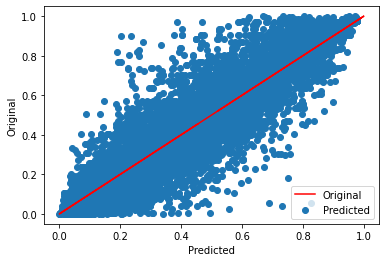

In [ ]:
# Scatterplot
plt.scatter(y_pred, y_test, label='Predicted')
plt.plot(y_test, y_test, label='Original', c = 'r')
plt.xlabel("Predicted")
plt.ylabel("Original")
plt.legend()

plt.show()